In [46]:
include("read_nu_dist_sphere.jl")
include("read_eff_area.jl")
include("read_energy_res.jl")
include("functions_utils.jl")

# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays
using Healpix
using BenchmarkTools
using CurveFit

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [2]:
# Loading the models and necessary data

model_1 = "galnu_GALcase2"
model_2 = "galnu_jo18"
model_3 = "galnu_me23"

# model_1 = readdlm("/Users/millermacdonald/Desktop/Research_shit/GP_nu_sim_data/$model1.txt", comments=true)
# model_2 = readdlm("/Users/millermacdonald/Desktop/Research_shit/GP_nu_sim_data/$model2.txt", comments=true)

#We need the length of the vectors for future calcs
# νmodel = vcat(model_1, model_2)
# numv = size(νmodel)[1]

# Getting spatial data
rs_1, ls_1, bs_1, rweights_1, logνes_1, logCRes_1 = read_models(model_1)
oneweights_1 = Weights(ones(length(rweights_1)))
rs_2, ls_2, bs_2, rweights_2, logνes_2, logCRes_2 = read_models(model_2)
oneweights_2 = Weights(ones(length(rweights_2)))
rs_3, ls_3, bs_3, rweights_3, logνes_3, logCRes_3 = read_models(model_3)
oneweights_3 = Weights(ones(length(rweights_3)))

# Getting the (previously unneeded) energy gc_data
minlogCRe_1, maxlogCRe_1 = minimum(logCRes_1), maximum(logCRes_1)
logCRebins_1 = range(minlogCRe_1, maxlogCRe_1, 100)
minlogCRe_2, maxlogCRe_2 = minimum(logCRes_2), maximum(logCRes_2)
logCRebins_2 = range(minlogCRe_2, maxlogCRe_2, 100)
minlogCRe_3, maxlogCRe_3 = minimum(logCRes_3), maximum(logCRes_3)
logCRebins_3 = range(minlogCRe_3, maxlogCRe_3, 100)

minlogνe_1, maxlogνe_1 = minimum(logνes_1), maximum(logνes_1)
logνebins_1 = range(minlogνe_1, maxlogνe_1, 100)
minlogνe_2, maxlogνe_2 = minimum(logνes_2), maximum(logνes_2)
logνebins_2 = range(minlogνe_2, maxlogνe_2, 100)
minlogνe_3, maxlogνe_3 = minimum(logνes_3), maximum(logνes_3)
logνebins_3 = range(minlogνe_3, maxlogνe_3, 100)
;

In [9]:
minlogνe = minimum([minlogνe_1, minlogνe_2, minlogνe_3])
maxlogνe = maximum([maxlogνe_1, maxlogνe_2, maxlogνe_3])

5.40280970918742

In [28]:
# Cut all neutrinos outside our effective area energy bounds

function energy_cut(rs, ls, bs, rweights, logνes, oneweights)
    concatmat = hcat(rs, ls, bs, rweights, logνes, oneweights)
    filtered_matrix_rows = [row for row in eachrow(concatmat) if log10(emin) <= row[5] <= log10(emax)]
    filtered_mat = hcat(filtered_matrix_rows...)
    fmat = transpose(filtered_mat)
end

cut_1 = energy_cut(rs_1, ls_1, bs_1, rweights_1, logνes_1, rweights_1)
rs_1_cut, ls_1_cut, bs_1_cut, rweights_1_cut, logνes_1_cut, oneweights_1_cut = cut_1[:,1], cut_1[:,2], cut_1[:,3], cut_1[:,4], cut_1[:,5], cut_1[:,6]

cut_2 = energy_cut(rs_2, ls_2, bs_2, rweights_2, logνes_2, rweights_2)
rs_2_cut, ls_2_cut, bs_2_cut, rweights_2_cut, logνes_2_cut, oneweights_2_cut = cut_2[:,1], cut_2[:,2], cut_2[:,3], cut_2[:,4], cut_2[:,5], cut_2[:,6]

cut_3 = energy_cut(rs_3, ls_3, bs_3, rweights_3, logνes_3, rweights_3)
rs_3_cut, ls_3_cut, bs_3_cut, rweights_3_cut, logνes_3_cut, oneweights_3_cut = cut_3[:,1], cut_3[:,2], cut_3[:,3], cut_3[:,4], cut_3[:,5], cut_3[:,6]
;

In [ ]:
power_law_flux(E, γ, ϕ₀=1, E0=1) = ϕ₀ * (E / E0)^(-γ)

function calc_mc_PL_weights!(rweights, loges, γ_inj, γ_sample)
    # inj = target spectrum
    # sample = spectrum we sampled at
    rweights .*= power_law_flux.( 10 .^ (loges), γ_inj - γ_sample)
end

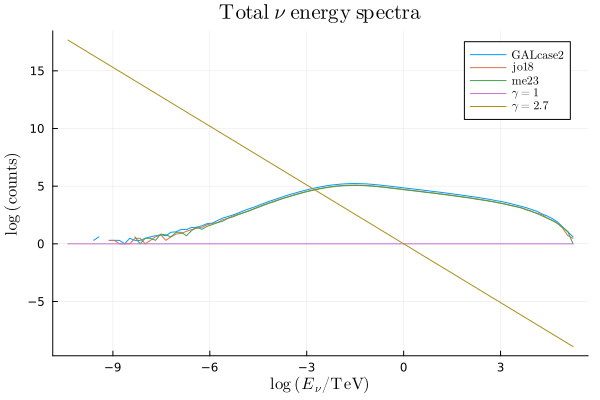

In [11]:
νehist_1 = fit(Histogram, logνes_1, logνebins_all, closed=:left)
logνeweights_1 = log10.(νehist_1.weights)
νehist_2 = fit(Histogram, logνes_2, logνebins_all, closed=:left)
logνeweights_2 = log10.(νehist_2.weights)
νehist_3 = fit(Histogram, logνes_3, logνebins_all, closed=:left)
logνeweights_3 = log10.(νehist_3.weights)

# CRehist = fit(Histogram, logCRes_1, logCRebins_1, closed=:left)
# logCReweights = log10.(CRehist.weights)

gamma1(x) = x^(0)
gamma27(x) = x^(-1.7)

logνsamples_γ1 = log10.(gamma1.(10 .^ (logνebins_all)))
logνsamples_γ27 = log10.(gamma27.(10 .^ (logνebins_all)))

# logCRsamples_γ1 = log10.(gamma1.(10 .^ (logCRebins_1)))
# logCRsamples_γ27 = log10.(gamma27.(10 .^ (logCRebins_1)))

plot(
    logνebins_all[1:end-1],
    [logνeweights_1 logνeweights_2 logνeweights_3 logνsamples_γ1[1:end-1] logνsamples_γ27[1:end-1]],
    label=[L"\mathrm{GALcase2}" L"\mathrm{jo18}" L"\mathrm{me23}" L"\gamma = 1" L"\gamma = 2.7"],
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\log~(\mathrm{counts})",
    title=L"\mathrm{Total~}\nu~\mathrm{energy~spectra}"
)

In [130]:
# Binning function that now bins energy as well

function weighthist_es(rs, ls, bs, loges, simws, fluxw; removed_bins=0, rbinsize=0.4, θbinsize=π/25, minloge=minlogνe, maxloge=maxlogνe, elength=50)

    rweights = Weights(simws ./ (rs .^ fluxw))

    power_law_flux(E, γ, ϕ₀=1, E0=1) = ϕ₀ * (E / E0)^(-γ)

    γ_inj = 2.7
    γ_sample = 1

    rweights .= Weights(rweights .* power_law_flux.( 10 .^ (loges), γ_inj - γ_sample))

    #=
    function calc_mc_PL_weights!(rweights, loges, γ_inj, γ_sample)
        # inj = target spectrum
        # sample = spectrum we sampled at
        rweights .*= power_law_flux.( 10 .^ (loges), γ_inj - γ_sample)
    end
    =#

    # We take square angular bins
    rbins, lbins, bbins, logebins = 0:rbinsize:20, -π:θbinsize:π, -π/2:θbinsize:π/2, range(minloge, maxloge, length=elength)

    # Histogramming the simulation by our radial and angular bins
    nuhist = fit(Histogram, (rs, ls, bs, loges), rweights, (rbins, lbins, bbins, logebins), closed=:left)
    nuweights = nuhist.weights

    # removing bins to see what happens... (we expect very few neutrinos within 0.1 kpc from Earth, so it's set to 1)
    if removed_bins > 0
        nuweights[1:removed_bins, :, :, :] .= 0
    end

    return nuweights

end

weighthist_es (generic function with 1 method)

In [178]:
# Binning by r, l, b, and energy

ebinning = weighthist_es(rs_1_cut, ls_1_cut, bs_1_cut, logνes_1_cut, rweights_1_cut, 2, minloge=log10(emin), maxloge=log10(emax))

# Summing over r and b to see e distribution dependence on l
es_vs_ls = [sum(ebinning[:, l, :, e])[1] for e in 1:49, l in 1:49]

# Summing over r and l to see e dist dependence on b
es_vs_bs = [sum(ebinning[:, :, b, e])[1] for e in 1:49, b in 1:24]

# Summing over l and b to see e dist dependence on r
es_vs_rs = [sum(ebinning[r, :, :, e])[1] for e in 1:49, r in 1:50]

# Column normalizing each energy dist
for i in 1:49
    es_vs_ls[:, i] = es_vs_ls[:, i] ./ sum(es_vs_ls[:, i])
end
for i in 1:24
    es_vs_bs[:, i] = es_vs_bs[:, i] ./ sum(es_vs_bs[:, i])
end
for i in 1:50
    es_vs_rs[:, i] = es_vs_rs[:, i] ./ sum(es_vs_rs[:, i])
end

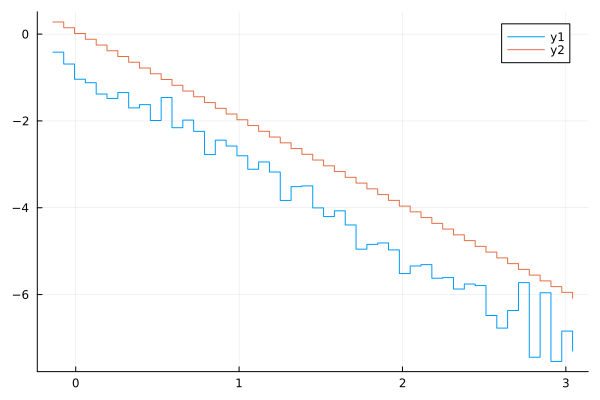

In [142]:
logerange = range(log10(emin), log10(emax), 49)
plot(
    logerange,
    [log10.(es_vs_ls[:, 1]) log10.((10 .^ logerange) .^ (-2))],
    seriestype=:step
)

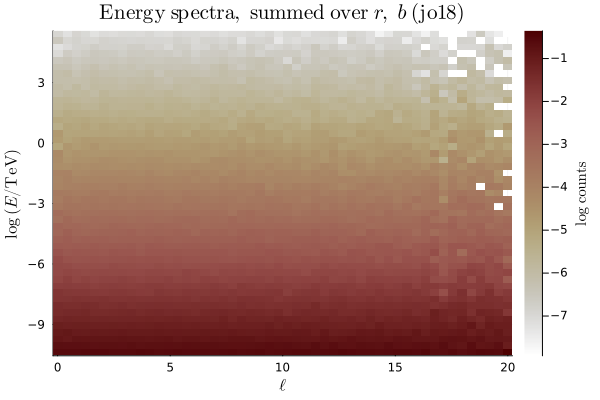

In [160]:
# Plotting

heatmap(
    range(0, 20, length=50),
    range(minlogνe, maxlogνe, length=49),
    log10.(es_vs_rs),
    c=:bilbao,
    title=L"\textrm{Energy~spectra,~summed~over~}r,~b~\textrm{(jo18)}",
    xlabel=L"\ell",
    ylabel=L"\log~(E/\mathrm{TeV})",
    colorbar_title=L"\mathrm{log~counts}"
)

In [179]:
logerange = range(log10(emin), log10(emax), 49)

gammas_by_r = [linear_fit(logerange, log10.(es_vs_rs[:, i]))[2] for i in 1:50]

50-element Vector{Float64}:
  -2.1144060556058073
  -2.060353224762979
  -2.065510677907752
  -2.0328528624334306
  -2.0332011524402893
  -2.0409652205385123
  -2.0388765698391844
  -2.0373898005022446
  -2.0468592886306087
  -2.013471842580891
  -2.0374129692086353
  -2.0244717476628526
  -2.0136479881022926
   ⋮
  -2.025742062734211
  -2.0375952771020307
  -2.0434256755897797
  -2.082303224541331
  -2.0075638231745963
  -2.102420479862534
 NaN
 NaN
  -2.0236990042136007
  -2.037898054951462
  -2.060275008820816
 NaN

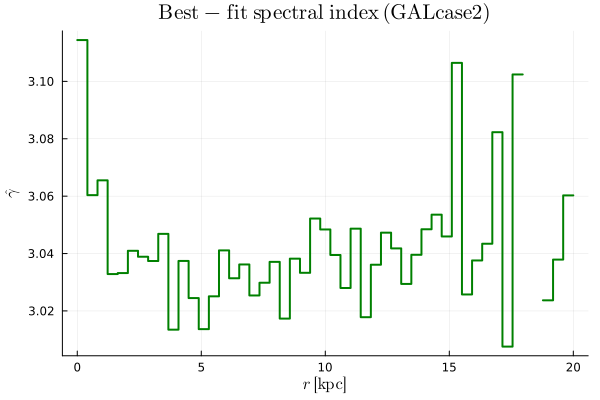

In [180]:
plot(range(0, 20, length=50),
    -(gammas_by_r .- 1),
    seriestype=:step,
    label=false,
    xlabel=L"r~\mathrm{[kpc]}",
    ylabel=L"\hat{\gamma}",
    title=L"\mathrm{Best-fit~spectral~index~(GALcase2)}",
    c=:green,
    lw=2
)

[ Info: Saved animation to /Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/logE_by_l_cut_me23.gif


Plots.AnimatedGif("/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/logE_by_l_cut_me23.gif")
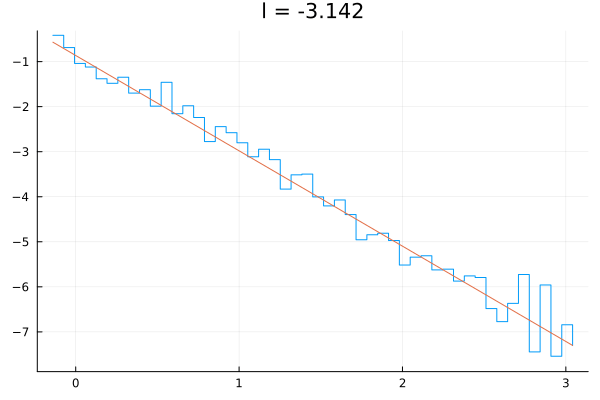

In [169]:
anim = @animate for i in 1:49
    logerange = range(log10(emin), log10(emax), 49)
    ls = range(-π, π, length=49)
    l = round(ls[i], digits=3)
    gamma_params = linear_fit(logerange, log10.(es_vs_ls[:, i]))
    gammafunc(x) = gamma_params[1] + x*gamma_params[2]
    plot(logerange,
        log10.(es_vs_ls[:, i]),
        seriestype=:step,
        label=false,
        ylims=(minimum(log10.(es_vs_ls)), maximum(log10.(es_vs_ls))),
        title="l = $l"
    )
    plot!(logerange, gammafunc.(logerange), label=false)
end

gif(anim, "logE_by_l_cut_me23.gif", fps=3)

In [300]:
function weighthist_es_1(rs, ls, bs, loges, simws, fluxw; removed_bins=1, rbinsize=0.1, θbinsize=π/100, elength=201)

    rweights = Weights(simws ./ (rs .^ fluxw))

    # We take square angular bins
    rbins, lbins, bbins, logebins = 0:rbinsize:20, -π:θbinsize:π, -π/2:θbinsize:π/2, range(log10(emin), log10(emax), length=elength)

    # Histogramming the simulation by our radial and angular bins
    nuhist = fit(Histogram, (rs, ls, bs, loges), rweights, (rbins, lbins, bbins, logebins), closed=:left)
    nuweights = nuhist.weights

    # removing bins to see what happens... (we expect very few neutrinos within 0.1 kpc from Earth, so it's set to 1)
    if removed_bins > 0
        nuweights[1:removed_bins, :, :, :] .= 0
    end

    return nuweights

end

weighthist_es_1 (generic function with 1 method)

In [302]:
lbbins = weighthist_es_1(rs_r2, ls_r2, bs_r2, logνes, rweights_r2, 2)

# 200 x 49

200×199×99×200 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0 

In [303]:
lbbin = lbbins[:, 100, 50, :]

200×200 Matrix{Float64}:
  0.0      0.0     0.0   0.0     0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0  16.5218  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0     13.1672  0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 62.1744  62.0293  0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0      0.0     0.0   0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [306]:
function oscprob(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_ee = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_μe = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))

    prob_eτ = osc*((u[3]*u[1]) + (u[6]*u[4]) + (u[9]*u[7]))
    prob_μτ = osc*((u[3]*u[2]) + (u[6]*u[5]) + (u[9]*u[8]))

    prob_eμ = osc*((u[2]*u[1]) + (u[5]*u[4]) + (u[8]*u[7]))
    prob_μμ = osc*((u[2]*u[2]) + (u[5]*u[5]) + (u[8]*u[8]))

    prob_e = 0.333333prob_ee + 0.666666prob_μe
    prob_τ = 0.333333prob_eτ + 0.666666prob_μτ
    prob_μ = 0.333333prob_eμ + 0.666666prob_μμ

    # νμ contribution comes from the 25% chance of a neutral current interaction, which appears as a cascade
    prob_cascade = prob_e + prob_τ + 0.25prob_μ
end

function dm2stuff(dm2)
    ers = 10 .^ loges
    rbins = range(0, 20, 200)

    # effareavec = effarea.(ers) * 10000
    oscprobmat = [oscprob(er, dm2, rbin) for rbin in rbins, er in ers]

    return transpose(oscprobmat) # .* transpose(effareavec)

end

# Energy ranges and getting the effective area vector
ers = 10 .^ loges
effareavec = effarea.(ers) * 10000

# Smearing matrix with effective area
energymat = erestrue * du .* transpose(effareavec)
;

In [307]:
nulloscmat = dm2stuff(0)

200×200 transpose(::Matrix{Float64}) with eltype Float64:
 0.735774  0.735774  0.735774  0.735774  …  0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774  …  0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774  …  0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.735774
 0.735774  0.735774  0.735774  0.735774     0.735774  0.735774  0.

In [314]:
unbs_edist = vec(sum(lbbin .* nulloscmat, dims=1)) .* effareavec

unb_edist = energymat * unbs_edist

200-element Vector{Float64}:
 9.562703344564293e10
 1.1874342335759715e11
 1.1874342335759715e11
 1.1874342335759715e11
 1.1874342335759715e11
 1.1874342335759715e11
 1.1874342335759715e11
 1.213325425710819e11
 1.213325425710819e11
 1.213325425710819e11
 1.213325425710819e11
 1.213325425710819e11
 1.213325425710819e11
 ⋮
 1.7284377244745438e10
 1.7284377244745438e10
 1.7284377244745438e10
 1.7284377244745438e10
 1.7284377244745438e10
 1.7284377244745438e10
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

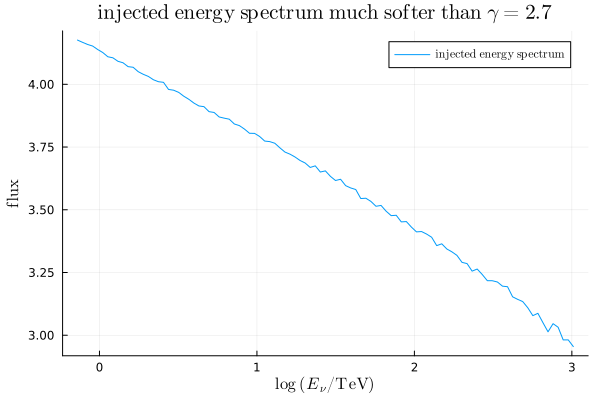

In [333]:
logebins = range(log10(emin), log10(emax), 100)
logehist = fit(Histogram, (logνes), (logebins), closed=:left)

powerlaw(x) = x^(-2.7)
plsample = powerlaw.(10 .^ logebins[1:end-1])

plot(
    logebins[1:end-1], 
    [log10.(logehist.weights)],
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\mathrm{flux}",
    label=[L"\mathrm{injected~energy~spectrum}" L"\gamma = 2.7"],
    title=L"\mathrm{injected~energy~spectrum~much~softer~than~\gamma=2.7}"
)

In [323]:
function smeared_edist(unbinned_edist)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    vec = unbinned_edist .* du .* (10 .^ loges) .* log(10)
    matrix = reshape(vec, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1) # This normalizing factor is to make total as null events = 748
end

smeared_edist (generic function with 1 method)

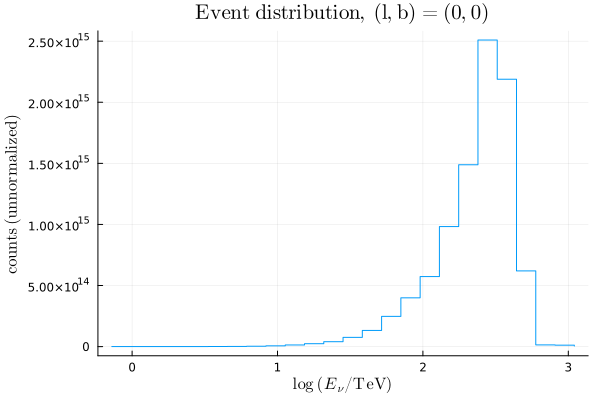

In [332]:
bs_edist = vec(smeared_edist(unb_edist))
plot(
    range(log10(emin), log10(emax), 25),
    bs_edist,
    seriestype=:step,
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\mathrm{counts~(unnormalized)}",
    title=L"\mathrm{Event~distribution,~(l, b) = (0, 0)}",
    label=false
)